# Linear Modeling of House Price

## 1. Introduction

## 2. Preparing the Dataset

In [29]:
import pandas as pd
import numpy as np
from Modules.dataexploration import DataExploration

pd.set_option('display.float', '{:,.2f}'.format)
pd.set_option('display.max_columns', 75)
pd.set_option('display.max_rows', 75)
pd.set_option('display.max_info_columns', 50)

In [30]:
house_df = pd.read_csv('Dataset\jabodetabek_house_data_prcsd.csv')

### 2.1. Subsetting the Test Set for Assessing Prediction

In [31]:
from sklearn.model_selection import train_test_split

X = house_df.drop('price_in_rp', axis=1)
y = house_df.price_in_rp

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=99
)

### 2.2. Missing Values

First let's review missing data from our original dataset (yes, not `train` or `test set`). By evaluating `original dataset`, we analyze the possibility of missing value for both scenarios.

In [32]:
numerical_features = house_df.select_dtypes(exclude=['object', 'category']).columns
DataExploration(house_df).show_nans_or_zeroes('nans', numerical_features)

,Nans Count,Nans Percentage (%),Data Types
price_in_rp,0,0.00,float64
lat,0,0.00,float64
long,0,0.00,float64
bedrooms,33,0.93,float64
bathrooms,29,0.82,float64
land_size_m2,2,0.06,float64
building_size_m2,2,0.06,float64
carports,0,0.00,int64
maid_bedrooms,0,0.00,int64
maid_bathrooms,0,0.00,int64


In [33]:
non_numeric_features = house_df.select_dtypes(include=['object']).columns
DataExploration(house_df).show_nans_or_zeroes('nans', non_numeric_features)

,Nans Count,Nans Percentage (%),Data Types
url,0,0.00,object
title,0,0.00,object
address,0,0.00,object
district,0,0.00,object
city,0,0.00,object
facilities,0,0.00,object
property_type,1,0.03,object
ads_id,4,0.11,object
certificate,140,3.96,object
electricity,0,0.00,object


Remember that those observations (from our original dataset) with missing records may exist in `training set`, `test set` or may be in both. Therefore, we must develop method to handle missing value that works for `training set`, `test set`, and even `potential future data` which we want to predict if any. Possible method:

1. Drop observations that have missing `bathrooms` or `bedrooms`, `land_size` and `building_size` records
2. Drop `building_age`, `year_built`, and `building_orientation` which have a lot of missing value
3. For missing `floors` and `electricity_num`, will be imputed. Features that used for imputation is best choosen according to its correlation coefficient (previous chapter).
4. For missing `certificate`, let's assume `certificate = lainnya`.
5. For missing `property_condition` and `furnishing`, let's assume majority of data.

According to above explanation, it should be noted that if there are any `future data` that we want to predict, the only missing features that can be considered are `floors`, `electricity`, `certificate`, `property_condition` and `furnishing`. Other than that, the prediction can't be performed.

In below codes, note that the imputation is fitted only with `train set` to ensure that the prediction model is isolated from `test set` (avoding data leakage)

In [34]:
from sklearn.impute import SimpleImputer, KNNImputer

# 1. Drop observations that missing vital records
X_train = X_train\
    .dropna(subset=['bedrooms', 'bathrooms', 'building_size_m2', 'land_size_m2'])
y_train = y_train[X_train.index] # remember to also drop the particular index of label data
X_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
# 2. Drop features with lot of NaN    
X_train = X_train\
    .drop(['building_age', 'year_built', 'building_orientation'], axis=1)
# 3.a. Impute missing `floors`
knn_imputer = KNNImputer(n_neighbors=1)
missing_floors_index = X_train[X_train.floors.isna()].index
features_estimator_floors = ['building_size_m2', 'bedrooms', 'bathrooms', 'floors']
imputer_floors = knn_imputer.fit(X_train[features_estimator_floors])
imputed_data_floors = imputer_floors.transform(X_train[features_estimator_floors])
X_train = X_train.assign(
    floors = imputed_data_floors[:, 3]
)
# 3.b. Impute missing `Electricity`
features_estimator_electricity = [
    'building_size_m2', 'bedrooms', 'bathrooms', 'floors', 'electricity_num'
]
missing_electricity_index = X_train[X_train.electricity_num.isna()].index
imputer_electricity = knn_imputer.fit(X_train[features_estimator_electricity])
imputed_data_electricity = imputer_electricity.transform(X_train[features_estimator_electricity])
X_train = X_train.assign(
    electricity_num = imputed_data_electricity[:, 4]
)
# 4. Impute missing `certificate`
constant_imputer = SimpleImputer(strategy='constant', fill_value='lainnya (ppjb,girik,adat,dll)')
X_train['certificate'] = constant_imputer.fit_transform(X_train[['certificate']]).flatten()
# 5. Impute missing `property_condition` and `furnishing`
frequent_imputer = SimpleImputer(strategy='most_frequent')
X_train['property_condition'] = frequent_imputer\
    .fit_transform(X_train[['property_condition']])\
    .flatten()
X_train['furnishing'] = frequent_imputer\
    .fit_transform(X_train[['furnishing']])\
    .flatten()

Let's see the imputation result:

In [35]:
# missing floor imputation results
show_features = ['building_size_m2', 'land_size_m2', 'bedrooms', 'bathrooms', 'floors']
pd.merge(
    X_train.iloc[missing_floors_index, X_train.columns.get_indexer(show_features)],
    y_train, left_index=True, right_index=True
)

,building_size_m2,land_size_m2,bedrooms,bathrooms,floors,price_in_rp
1328,600.00,250.00,3.00,3.00,3.00,"13,000,000,000.00"
1480,358.00,200.00,4.00,4.00,3.00,"10,100,000,000.00"
2261,200.00,187.00,3.00,3.00,2.00,"2,750,000,000.00"
2765,250.00,320.00,4.00,4.00,2.00,"8,300,000,000.00"


In [36]:
# missing electricity imputation results
show_features = ['building_size_m2', 'land_size_m2', 'bedrooms', 'bathrooms', 'floors', 'electricity_num']
pd.merge(
    X_train\
    .iloc[missing_electricity_index, X_train.columns.get_indexer(show_features)]\
    .head(),
    y_train, left_index=True, right_index=True
)

,building_size_m2,land_size_m2,bedrooms,bathrooms,floors,electricity_num,price_in_rp
5,249.00,180.00,4.00,3.00,2.00,"3,300.00","3,550,000,000.00"
7,194.00,112.00,4.00,3.00,3.00,"3,500.00","3,000,000,000.00"
9,285.00,220.00,4.00,4.00,2.00,"7,700.00","7,400,000,000.00"
11,200.00,"5,250.00",4.00,3.00,1.00,"3,500.00","63,000,000,000.00"
39,134.00,105.00,4.00,4.00,1.00,"3,500.00","3,830,000,000.00"


### 2.3. Unnecessary Features and Features with High Cardinality

In [37]:
cols_to_drop = ['url', 'title', 'address', 'district', 'ads_id', 'facilities', 'property_type', 'electricity']
X_train.drop(cols_to_drop, axis=1, inplace=True)

### 2.4. Conclusion: Prepared Features

In [38]:
numerical_features = X_train.select_dtypes(exclude=['object', 'category']).columns
DataExploration(X_train).show_nans_or_zeroes('nans', numerical_features)

,Nans Count,Nans Percentage (%),Data Types
lat,0,0.00,float64
long,0,0.00,float64
bedrooms,0,0.00,float64
bathrooms,0,0.00,float64
land_size_m2,0,0.00,float64
building_size_m2,0,0.00,float64
carports,0,0.00,int64
maid_bedrooms,0,0.00,int64
maid_bathrooms,0,0.00,int64
floors,0,0.00,float64


In [39]:
non_numeric_features = X_train.select_dtypes(include=['object']).columns
DataExploration(X_train).show_nans_or_zeroes('nans', non_numeric_features)

,Nans Count,Nans Percentage (%),Data Types
city,0,0.00,object
certificate,0,0.00,object
property_condition,0,0.00,object
furnishing,0,0.00,object


### 2.5. Additional: Pipeline for Test Set

#### **Transformer to drop Observations with Missing Records**

In [40]:
from sklearn.base import BaseEstimator, TransformerMixin

class RowsDropper(BaseEstimator, TransformerMixin):
    """ 
    Remove observations that missing any records from features that
    specified in `mandatory_features` 
    """
    def __init__(self, mandatory_features):
        self.mandatory_features = mandatory_features.copy()
        self.dropped_index = []

    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        self.dropped_index = X[X[self.mandatory_features].isna()].index
        X_new = X.dropna(subset=self.mandatory_features)
        X_new.reset_index(drop=True, inplace=True)
        return X_new
    
    def fit_transform(self, X, y=None, **fit_params):
        return self.fit(X, **fit_params).transform(X)

#### **Features-Dropper Transformer**

In [41]:
class FeaturesDropper(BaseEstimator, TransformerMixin):
    def __init__(self, drop_list):
        self.drop_list = drop_list.copy()
        self.cols_dropped = []

    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        # checking if streamed data has unused features
        self.cols_dropped +=\
            [column for column in X.columns if column in self.drop_list]
        if self.cols_dropped:
            X_new = X.drop(self.cols_dropped, axis=1)
            return X_new
        else:
            return X
    
    def fit_transform(self, X, y=None, **fit_params):
        return self.fit(X, **fit_params).transform(X)

#### **Transformer for Specific Columns**

In [42]:
class FloorsKNNImputer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self._knn_imputer = KNNImputer(n_neighbors=1)
        self._features_estimator_floors = ['building_size_m2', 'bedrooms', 'bathrooms', 'floors']

    def fit(self, X, y=None):
        X_fit = X.copy()
        self._knn_imputer = self._knn_imputer.fit(X_fit[self._features_estimator_floors])
        return self

    def transform(self, X, y=None):
        X_transf = X.copy()
        imputed_data_floors = self._knn_imputer.transform(X_transf[self._features_estimator_floors])
        X_new = X_transf.assign(
            floors = imputed_data_floors[:, 3]
        )
        return X_new
    
    def fit_transform(self, X, y=None, **fit_params):
        return self.fit(X, **fit_params).transform(X)

class ElectricityKNNImputer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self._knn_imputer = KNNImputer(n_neighbors=1)
        self._features_estimator_electricity = \
            ['building_size_m2', 'bedrooms', 'bathrooms', 'floors', 'electricity_num']

    def fit(self, X, y=None):
        X_fit = X.copy()
        self._knn_imputer = self._knn_imputer.fit(X_fit[self._features_estimator_electricity])
        return self

    def transform(self, X, y=None):
        X_transf = X.copy()
        imputed_data_electricity = self._knn_imputer.transform(X_transf[self._features_estimator_electricity])
        X_new = X_transf.assign(
            electricity_num = imputed_data_electricity[:, 4]
        )
        return X_new
    
    def fit_transform(self, X, y=None, **fit_params):
        return self.fit(X, **fit_params).transform(X)

#### **Creating Pipeline for Train-Test Set**

In [43]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn import set_config

mandatory_features = ['price_in_rp', 'bedrooms', 'bathrooms', 'building_size_m2', 'land_size_m2']
columns_to_drop = [
            'building_age', 'year_built', 'building_orientation',
            'url', 'title', 'address', 'district', 'ads_id', 'facilities', 
            'property_type', 'electricity'
            ]
rows_dropper = RowsDropper(mandatory_features)
features_dropper = FeaturesDropper(columns_to_drop)
floors_imputer = FloorsKNNImputer()
electricity_imputer = ElectricityKNNImputer()
certificate_imputer = SimpleImputer(strategy='constant', fill_value='lainnya (ppjb,girik,adat,dll)')
features_transf = ColumnTransformer([
    ('certificate_impute', certificate_imputer, ['certificate']),
    ('property_condition_impute', SimpleImputer(strategy='most_frequent'), ['property_condition']),
    ('furnishing_impute', SimpleImputer(strategy='most_frequent'), ['furnishing'])
    ], remainder='passthrough')
dataset_transform_pipeline = make_pipeline(
    rows_dropper,
    features_dropper,
    floors_imputer,
    electricity_imputer,
    features_transf
    )

set_config(display='diagram')
dataset_transform_pipeline

Pipeline(steps=[('rowsdropper',
                 RowsDropper(mandatory_features=['price_in_rp', 'bedrooms',
                                                 'bathrooms',
                                                 'building_size_m2',
                                                 'land_size_m2'])),
                ('featuresdropper',
                 FeaturesDropper(drop_list=['building_age', 'year_built',
                                            'building_orientation', 'url',
                                            'title', 'address', 'district',
                                            'ads_id', 'facilities',
                                            'property_type', 'electricity'])),
                ('floorsknnimputer', Floors...
                ('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('certificate_impute',
                                                  SimpleImputer(fill_value='lainnya '
                                                                           '(ppjb,girik,adat,dll)',
                                                                strategy='constant'),
                                                  ['certificate']),
                                                 ('property_condition_impute',
                                                  SimpleImputer(strategy='most_frequent'),
                                                  ['property_condition']),
                                                 ('furnishing_impute',
                                                  SimpleImputer(strategy='most_frequent'),
                                                  ['furnishing'])]))])

#### **Demonstrating Pipeline for Train Set**

In [44]:
df_train, df_test =  train_test_split(house_df, test_size=0.1, random_state=99)

In [45]:
transfd_columns = ['certificate', 'property_condition', 'furnishing']
dataset_columns = \
    transfd_columns + [column for column in house_df.drop(columns_to_drop, axis=1) if column not in transfd_columns]

train_set_transfd = pd.DataFrame(
    dataset_transform_pipeline.fit_transform(df_train), 
    columns=dataset_columns)
for column in train_set_transfd.columns:
    train_set_transfd[column] = pd.to_numeric(train_set_transfd[column], errors='ignore')
    
DataExploration(train_set_transfd).show_nans_or_zeroes('nans')

,Nans Count,Nans Percentage (%),Data Types
certificate,0,0.00,object
property_condition,0,0.00,object
furnishing,0,0.00,object
price_in_rp,0,0.00,float64
city,0,0.00,object
lat,0,0.00,float64
long,0,0.00,float64
bedrooms,0,0.00,float64
bathrooms,0,0.00,float64
land_size_m2,0,0.00,float64


In [46]:
# missing floor imputation results
show_features = ['building_size_m2', 'land_size_m2', 'bedrooms', 'bathrooms', 'floors', 'price_in_rp']
train_set_transfd .iloc[missing_floors_index, train_set_transfd .columns.get_indexer(show_features)]

,building_size_m2,land_size_m2,bedrooms,bathrooms,floors,price_in_rp
1328,600.00,250.00,3.00,3.00,3.00,"13,000,000,000.00"
1480,358.00,200.00,4.00,4.00,3.00,"10,100,000,000.00"
2261,200.00,187.00,3.00,3.00,2.00,"2,750,000,000.00"
2765,250.00,320.00,4.00,4.00,2.00,"8,300,000,000.00"


In [47]:
# missing electricity imputation results
show_features = ['building_size_m2', 'land_size_m2', 'bedrooms', 'bathrooms', 'floors', 'electricity_num', 'price_in_rp']
train_set_transfd \
    .iloc[missing_electricity_index, train_set_transfd.columns.get_indexer(show_features)]\
    .head()

,building_size_m2,land_size_m2,bedrooms,bathrooms,floors,electricity_num,price_in_rp
5,249.00,180.00,4.00,3.00,2.00,"3,300.00","3,550,000,000.00"
7,194.00,112.00,4.00,3.00,3.00,"3,500.00","3,000,000,000.00"
9,285.00,220.00,4.00,4.00,2.00,"7,700.00","7,400,000,000.00"
11,200.00,"5,250.00",4.00,3.00,1.00,"3,500.00","63,000,000,000.00"
39,134.00,105.00,4.00,4.00,1.00,"3,500.00","3,830,000,000.00"


As explained before, the advantage of using pipeline is to assure that necessary dataset transformation can also be applied for the data independent of `train-test set`. As an example, here we will transform the *suspicious* house data records (as identified in Chapter 2) that has been isolated for analysis purposes.

In [48]:
suspicious_records = pd.read_csv('Dataset/suspicious_records.csv')
sus_set = pd.DataFrame(
    dataset_transform_pipeline.transform(suspicious_records), 
    columns=dataset_columns)

for column in sus_set.columns:
    sus_set[column] = pd.to_numeric(sus_set[column], errors='ignore')

In [49]:
DataExploration(sus_set).show_nans_or_zeroes('nans')

,Nans Count,Nans Percentage (%),Data Types
certificate,0,0.00,object
property_condition,0,0.00,object
furnishing,0,0.00,object
price_in_rp,0,0.00,float64
city,0,0.00,object
lat,0,0.00,float64
long,0,0.00,float64
bedrooms,0,0.00,int64
bathrooms,0,0.00,int64
land_size_m2,0,0.00,float64


#### **Demonstrating Pipeline for Test Set**

In [50]:
test_set_transfd = pd.DataFrame(dataset_transform_pipeline.transform(df_test), columns=dataset_columns)
for column in test_set_transfd.columns:
    test_set_transfd[column] = pd.to_numeric(test_set_transfd[column], errors='ignore')
DataExploration(test_set_transfd).show_nans_or_zeroes('nans')

,Nans Count,Nans Percentage (%),Data Types
certificate,0,0.00,object
property_condition,0,0.00,object
furnishing,0,0.00,object
price_in_rp,0,0.00,float64
city,0,0.00,object
lat,0,0.00,float64
long,0,0.00,float64
bedrooms,0,0.00,float64
bathrooms,0,0.00,float64
land_size_m2,0,0.00,float64


#### **Exporting Train-Test Set for other Models**

In [51]:
from joblib import dump

dump(dataset_transform_pipeline, 'Output\dataset_transform_pipeline.joblib')

['Output\\dataset_transform_pipeline.joblib']

In [52]:
# Train set
X_train = train_set_transfd.drop('price_in_rp', axis=1)
y_train = train_set_transfd[['price_in_rp']]
# Test set
X_test = test_set_transfd.drop('price_in_rp', axis=1)
y_test = test_set_transfd[['price_in_rp']]
# Export to csv
X_train.to_csv('Dataset/X_train.csv')
y_train.to_csv('Dataset/y_train.csv')
X_test.to_csv('Dataset/X_test.csv')
y_test.to_csv('Dataset/y_test.csv')


## 3. Linear Modeling: Ordinary Least Square

### 3.1. Simple Linear Regression

In [53]:
import statsmodels.formula.api as smf
from statsmodels.stats.anova import anova_lm
from statsmodels.api import OLS
from statsmodels.tools import add_constant

X = train_set_transfd
X = add_constant(X)
# regression formula
f = 'price_in_rp ~ building_size_m2'
lm = smf.ols(formula=f, data=X)
results = lm.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            price_in_rp   R-squared:                       0.467
Model:                            OLS   Adj. R-squared:                  0.467
Method:                 Least Squares   F-statistic:                     2756.
Date:                Mon, 24 Oct 2022   Prob (F-statistic):               0.00
Time:                        18:14:47   Log-Likelihood:                -75842.
No. Observations:                3145   AIC:                         1.517e+05
Df Residuals:                    3143   BIC:                         1.517e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept        -9.315e+08    1.6e+08     -5.832      0.000   -1.24e+09   -6.18e+08
building_size_m2   2.65e+07   5.05e+05     52.496      0.000    2.55e+07    2.75e+07
==============================================================================
Omnibus:                     5545.774   Durbin-Watson:                   1.672
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         11155367.935
Skew:                          12.074   Prob(JB):                         0.00
Kurtosis:                     293.767   Cond. No.                         394.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

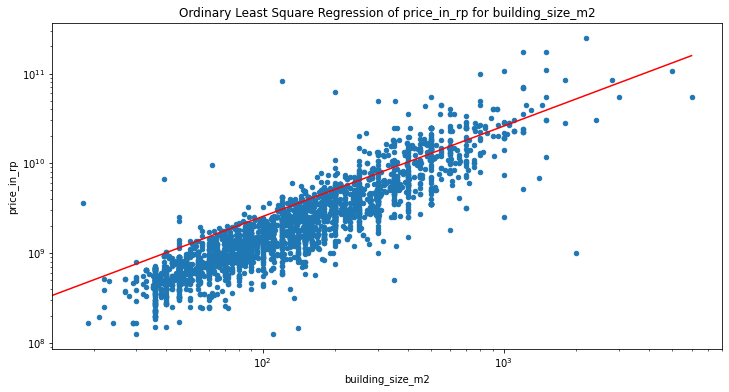

In [54]:
import matplotlib.pyplot as plt
import seaborn as sns

# linear OLS
x_linear = pd.DataFrame(
    {'building_size_m2': [0, X['building_size_m2'].max()]}
)
x_linear = add_constant(x_linear)
y_linear = results.predict(x_linear)

# plot
fig, ax = plt.subplots(figsize=(14, 6))
X.plot(kind='scatter', x='building_size_m2', y='price_in_rp', ax=ax)
sns.lineplot(x=x_linear['building_size_m2'], y=y_linear, color='r', ax=ax)
ax.set_title('Ordinary Least Square Regression of price_in_rp for building_size_m2')
ax.set_xscale('log')
ax.set_yscale('log')
 

#### **Residual Analysis of Simple Linear Regression**

Text(0, 0.5, 'residual')

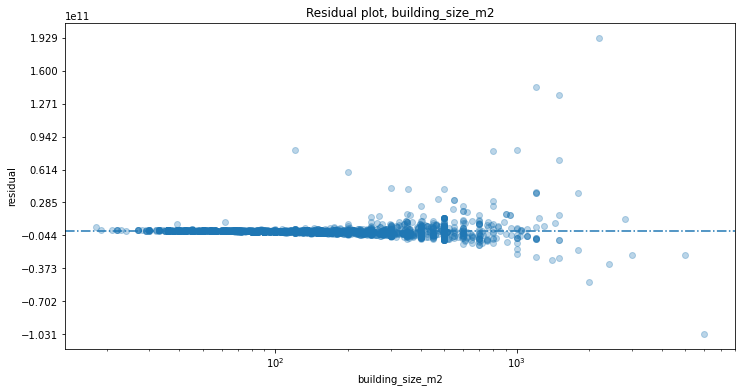

In [92]:
y_predict = results.predict(exog=X).values.reshape(-1, 1)
y = y_train.price_in_rp.values.reshape(-1, 1)
resid = y - y_predict
# matpltlib plot
fig, ax = plt.subplots(figsize=(14, 6))
ax.scatter(x=X_train.building_size_m2.values.reshape(-1, 1), y=resid, alpha=0.3)
ax.axhline(y=resid.mean(), linestyle='-.')
ax.set_title('Residual plot, building_size_m2')
ax.set_yticks(np.linspace(resid.min(), resid.max(), 10))
ax.set_xscale('log')
ax.set_xlabel('building_size_m2')
ax.set_ylabel('residual')

Text(0, 0.5, 'Residual')

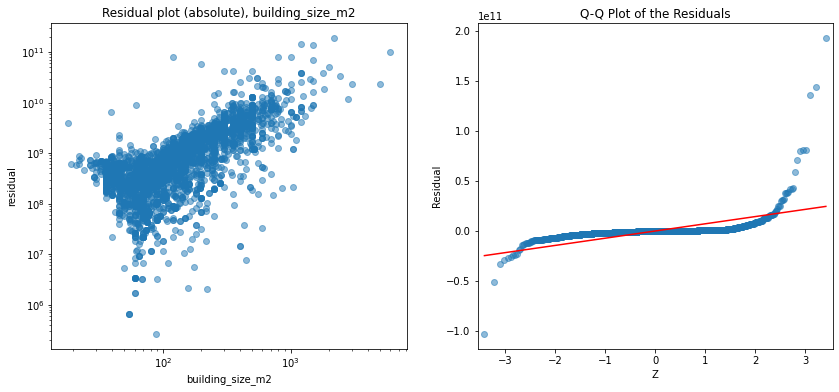

In [203]:
from statsmodels.graphics.gofplots import ProbPlot

# residual plot
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
ax[0].scatter(x=X_train.building_size_m2.values.reshape(-1, 1), y=abs(resid), alpha=0.5)
ax[0].set_title('Residual plot (absolute), building_size_m2')
ax[0].set_yticks(np.linspace(resid.min(), resid.max(), 10))
ax[0].set_xscale('log') 
ax[0].set_yscale('log', nonpositive='mask')
ax[0].set_xlabel('building_size_m2')
ax[0].set_ylabel('residual')
# Q-Q Plot
pplot = ProbPlot(resid.flatten())
pplot.qqplot(ax=ax[1], alpha=0.5, line='s')
ax[1].set_title('Q-Q Plot of the Residuals')
ax[1].set_xlabel('Z')
ax[1].set_ylabel('Residual')

#### **Residual, Leverage Point, Cook Distance**

#### **Inference of `building_size_m2` parameter**

We are going to use `paired bootstrap` to estimate distribution of `building_size_m2` parameter.

In [265]:
from scipy.stats import bootstrap

def coefficient(x, y):
    x_ = x.copy()
    y_ = y.copy()
    rows = x_.size
    np.c_[x_, np.repeat(1, rows)]
    lm = OLS(y_, x_)
    results = lm.fit()
    coeff = results.params[0]
    return coeff

X = X_train['building_size_m2'].values
y = y_train['price_in_rp'].values
sample = ((X, y))
bootstrap_res = bootstrap(
    sample, coefficient, vectorized=False, paired=True, random_state=99, 
    confidence_level=0.95
)
pd.DataFrame(
    [{'interval': 'OLS bootstrap', 
    'ci_low': bootstrap_res.confidence_interval[0],
    'ci_high': bootstrap_res.confidence_interval[1]},
    ]
).append(
    results.summary().tables[1].iloc[1, ]
)

interval,ci_low,ci_high
OLS bootstrap,19755249.668401,29611735.199810


Compare it to interval calculated using *student's t distribution* based on standard error of the coefficient:

In [285]:
results.summary(alpha=0.05).tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-9.315e+08,1.6e+08,-5.832,0.000,-1.24e+09,-6.18e+08
building_size_m2,2.65e+07,5.05e+05,52.496,0.000,2.55e+07,2.75e+07


For large sample, it is known that inference of regression coefficient *using student's t-distribution* will covers the *violation of normality* since *t-distribution will converge to normal*, but we won't know for sure how large of `n sample` is large enough for our dataset. But what is known that the largeness of `n` is highly affected by dataset skewness, in which our dataset suffers highly. Our model with `building_size_m2` also suffers from `non-constant variance`, which also affect the validity of our *t-distribution*.

The confidence interval is quite narrow (compared to the bootstrap result). The safer choice will be the `bootstrap confidence interval` due to reasons above.

As we hope that the bootstrap result portrays the true distribution of coefficient (confidently if we are very sure the dataset covers the population data well enough), the possibility of `building_size_m2` value can be identified by using below bootstrap plot.

Text(0, 0.5, 'Residual')

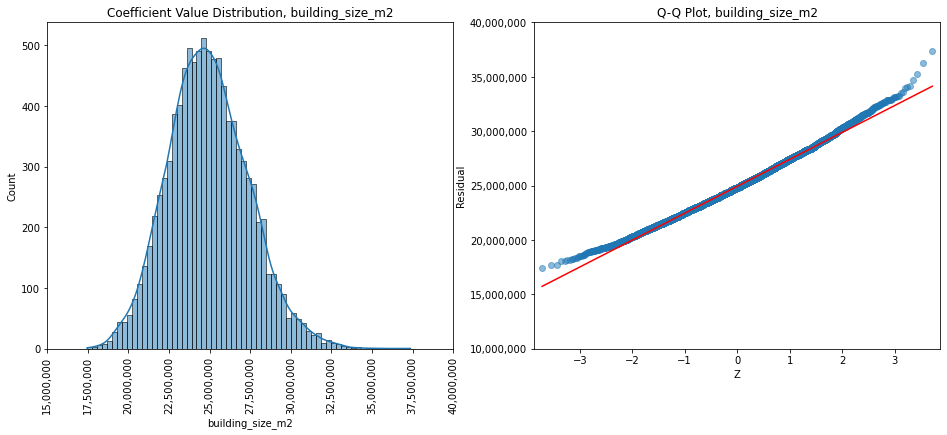

In [325]:
def coefficient_with_repl(x, y):
    rows = x.size
    resample_idx = np.random.choice(rows, size=rows, replace=True)
    x_ = x[resample_idx]
    y_ = y[resample_idx]
    np.c_[x_, np.repeat(1, rows)]
    lm = OLS(y_, x_)
    results = lm.fit()
    coeff = results.params[0]
    return coeff

# determining parameters for bootstrap
X = X_train['building_size_m2'].values
y = y_train['price_in_rp'].values
n_iter = 9999
# bootstrapping
a = np.empty((n_iter, 1))
bootstrap_coeff_value = np.apply_along_axis(lambda x: coefficient_with_repl(X, y), 1, a)
# plotting bootstrap result
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
sns.histplot(
    x=bootstrap_coeff_value, kde=True, ax=ax[0]
    )
# Q-Q Plot
pplot = ProbPlot(bootstrap_coeff_value.flatten())
pplot.qqplot(ax=ax[1], alpha=0.5, line='s')
xticks = ax[0].get_xticks()
ax[0].set_title('Coefficient Value Distribution, building_size_m2')
ax[0].set_xticks(xticks)
ax[0].set_xticklabels(['{:,.0f}'.format(x) for x in xticks], rotation=90)
ax[0].set_xlabel('building_size_m2')
yticks = ax[1].get_yticks()
ax[1].set_yticks(yticks)
ax[1].set_yticklabels(['{:,.0f}'.format(y) for y in yticks])
ax[1].set_title('Q-Q Plot, building_size_m2')
ax[1].set_xlabel('Z')
ax[1].set_ylabel('Residual')


As seen above, the coefficient distribution is quite skewed, which not yet close to our `symmetric t-distribution` caused by incorrect t-distribution due to non-constant variance. 

The distribution is also fat-tailed, in which the sample size effect doesn't quite make the distribution *converge to normality* yet.

Both the skewed and fat-tailed distribution will be considered in `BCa Corrected Interval` that has been calculated by using `scipy.stats.bootstrap` program, making the `bootstrap ci` resulting in the more confidence choice of CI calculation.

#### **Prediction Interval of Simple Regression**

### 3.2. Multiple Linear Regression